In [ ]:
#importing libraries
from urllib import request
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tmtoolkit as tm
from tmtoolkit.corpus import Corpus
import spacy
from tmtoolkit.corpus import *
import pandas as pd
from nltk.corpus import opinion_lexicon
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

In [ ]:
# downloading book 
def process_book(name):
    url = "https://www.gutenberg.org/cache/epub/" + name + "/pg" + name + ".txt"
    
    response = request.urlopen(url)
    raw_text = response.read().decode('utf8')

    # removing non-book parts
    raw_text=raw_text.split('***')
    raw_text = raw_text[2]  

    file = open('Lab_4_docs/' + name + ".txt", "w", encoding="utf-8")
    file.write(raw_text)
    file.close()

# book - A CHRISTMAS CAROL By CHARLES DICKENS
process_book("19337")

In [ ]:
# creating corpus, cleaning
spacy.load('en_core_web_sm')
corp = tm.corpus.Corpus.from_folder("Lab_4_docs", language="en", load_features=[])

text=[doc_texts(corp)['19337']]
labels=['19337']
corp = tm.corpus.Corpus(dict(zip(labels, text)), language = "en")

tm.corpus.remove_punctuation(corp)
tm.corpus.to_lowercase(corp)
tm.corpus.remove_tokens(corp, "")
tm.corpus.filter_clean_tokens(corp)

In [ ]:
# table of bigrams
bigrams = tm.corpus.corpus_ngramify(corp, n = 2, inplace=False)
tab_bigrams = tm.corpus.tokens_table(bigrams)
tab_bigrams

,doc,position,token,is_punct,is_stop,lemma,like_num,pos,tag
0,19337,0,produced jason,False False,False False,produce Jason,False False,VERB PROPN,VBN NNP
1,19337,1,jason isbell,False False,False False,Jason Isbell,False False,PROPN PROPN,NNP NNP
2,19337,2,isbell online,False False,False False,Isbell Online,False False,PROPN PROPN,NNP NNP
3,19337,3,online distributed,False False,False False,Online Distributed,False False,PROPN PROPN,NNP NNP
4,19337,4,distributed proofreading,False False,False False,Distributed Proofreading,False False,PROPN PROPN,NNP NNP
...,...,...,...,...,...,...,...,...,...
12329,19337,12329,said tiny,False False,False False,say Tiny,False False,VERB PROPN,VBN NNP
12330,19337,12330,tiny tim,False False,False False,Tiny Tim,False False,PROPN PROPN,NNP NNP
12331,19337,12331,tim observed,False False,False False,Tim observe,False False,PROPN VERB,NNP VBD
12332,19337,12332,observed god,False False,False False,observe God,False False,VERB PROPN,VBD NNP


In [ ]:
# splitting bigrams into 2 parts
df_token = tab_bigrams["token"].str.split(expand = True).add_prefix("token")
df_token = df_token[["token0", "token1"]]

# splitting pos (part-of-speech)
df_pos = tab_bigrams["pos"].str.split(expand = True).add_prefix("pos")
df_pos = df_pos[["pos0", "pos1"]]

df_token_pos = pd.concat([df_token,df_pos], axis=1)

df_token_pos

,token0,token1,pos0,pos1
0,produced,jason,VERB,PROPN
1,jason,isbell,PROPN,PROPN
2,isbell,online,PROPN,PROPN
3,online,distributed,PROPN,PROPN
4,distributed,proofreading,PROPN,PROPN
...,...,...,...,...
12329,said,tiny,VERB,PROPN
12330,tiny,tim,PROPN,PROPN
12331,tim,observed,PROPN,VERB
12332,observed,god,VERB,PROPN


In [ ]:
# using lemmatizer
lemmatizer = WordNetLemmatizer()

# negative and positive words
neg = set(opinion_lexicon.negative())
pos = set(opinion_lexicon.positive())

# words I want to check
words = ['scrooge', 'christmas', 'man', 'ghost']

WORD: scrooge
number of positive words (+1) before scrooge: 17
number of negative words (-1) before scrooge: 23
sum: -6
    pos0  pos0_freq
0   VERB        188
1   NOUN        109
2  PROPN         43
3    ADJ         21
4    ADV         10
5    ADP          2
6    AUX          1
7   INTJ          1


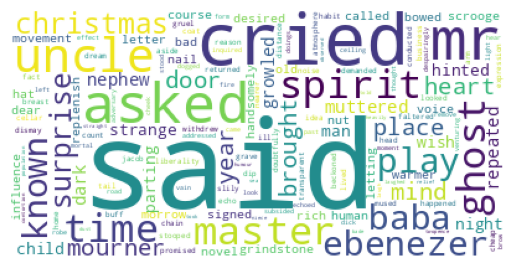

WORD: christmas
number of positive words (+1) before christmas: 28
number of negative words (-1) before christmas: 5
sum: 23
    pos0  pos0_freq
0  PROPN         27
1   NOUN         25
2   VERB         21
3    ADJ         19
4    NUM          3
5    ADV          1


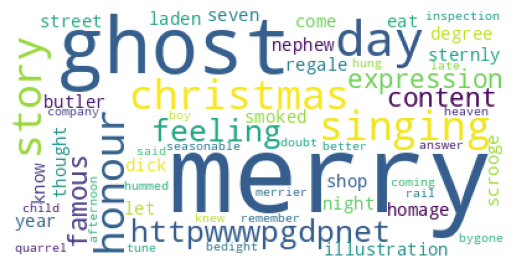

WORD: man
number of positive words (+1) before man: 7
number of negative words (-1) before man: 11
sum: -4
    pos0  pos0_freq
0    ADJ         28
1   VERB         20
2   NOUN         19
3  PROPN          8
4   INTJ          2
5    ADV          1
6    ADP          1


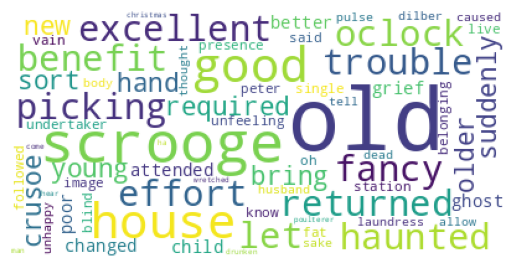

WORD: ghost
number of positive words (+1) before ghost: 2
number of negative words (-1) before ghost: 6
sum: -4
    pos0  pos0_freq
0   VERB         50
1   NOUN         24
2    ADJ         11
3  PROPN         10


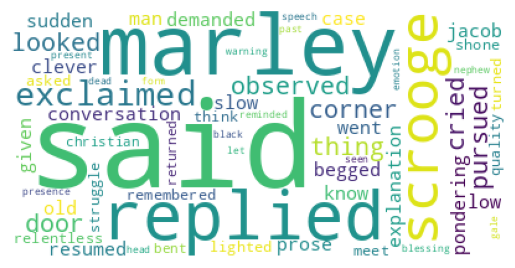

In [ ]:
#counting negative and positive words before the given word - to check how is it described
for i in words:
    print('WORD: ' + i)
    df_word = df_token_pos[df_token_pos.token1 == i].copy()
    
    # lemmatizing
    df_word['token0_lem'] = df_word['token0'].apply(lemmatizer.lemmatize)

    # count positive words
    sent = pd.DataFrame([(tok, tok in pos, tok in neg) for tok in df_word["token0_lem"]], columns=["tok", "pos", "neg"])
    positive = (sent['pos'] == 1).sum()
    print("number of positive words (+1) before " + i + ":", positive)

    # count negative words
    negative = (sent['neg'] == 1).sum()
    print("number of negative words (-1) before " + i + ":", negative)
    print('sum: ' + str(positive-negative))

    # check pos of 1st word in bigram
    df_word['pos0_freq'] = df_word.groupby('pos0')['pos0'].transform('count')
    df_pos0 = df_word[['pos0','pos0_freq']]
    df_pos0 = df_pos0.drop_duplicates()
    print(df_pos0.sort_values(by=['pos0_freq'], ascending=False).reset_index(drop=True))


    # generate wordclout
    wordcloud = WordCloud(background_color="white").generate(' '.join(df_word["token0_lem"]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()